# Heartbeat Classification with Machine Learning

### Loading and Exploring Heartbeat dataset

We have heartbeat dataset. To analyze this dataset, we need to incorporate time sequence along with the audio signals to capture the underlying patterns. We will load the dataset with libroas. First, let us cisualize how a sample audio data looks when sound amplitude is plotted against time

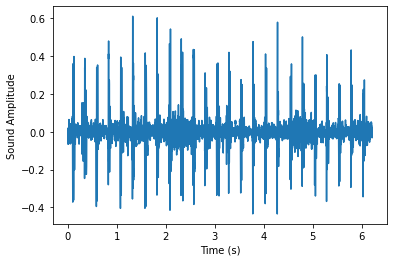

In [1]:

data_dir = 'dataset/kaggle/normal'
import librosa as lr
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

# List all the wav files in the folder
audio_files = glob(data_dir + '/*.wav')

# Read in the first audio file, create the time array
audio, sfreq = lr.load(audio_files[0])
time = np.arange(0, len(audio)) / sfreq

# Plot audio over time
fig, ax = plt.subplots()
ax.plot(time, audio)
ax.set(xlabel='Time (s)', ylabel='Sound Amplitude')
plt.show()

In [2]:
print(sfreq)
print(len(audio))
audio

22050
136925


array([-0.03442627, -0.04003989, -0.04242501, ...,  0.0022146 ,
        0.00193785,  0.00121363], dtype=float32)

Let us create a helper function to load the two datasets into two dataframes: `normal` and `abnormal`

In [3]:
import os
import pandas as pd

# Function to load audio files and create a DataFrame
def load_audio_files_to_df(folder_path):
    # List all .wav files in the folder
    audio_files = glob(folder_path + '/*.wav')
    
    # Initialize a list to hold the loaded audio data
    audio_data_list = []

    # Load each audio file
    for file in audio_files:
        # Load the audio file
        audio, sr = lr.load(file, sr=None)
        audio_data_list.append(audio)
    
    # Find the maximum length of the audio files
    max_length = max(len(audio) for audio in audio_data_list)

    # Pad shorter audio files with zeros to match the maximum length
    padded_audio_data_list = [np.pad(audio, (0, max_length - len(audio)), 'constant') for audio in audio_data_list]

    # Convert the list to a NumPy array and then to a DataFrame
    audio_data_array = np.array(padded_audio_data_list).T
    df = pd.DataFrame(audio_data_array)
    
    return df, sr

Now let us use this helper function to create the two dataframes. 

In [4]:


# Load normal heartbeat audio files into a DataFrame
normal_dir = 'dataset/kaggle/normal'
normal, sfreq = load_audio_files_to_df(normal_dir)

# Load abnormal heartbeat audio files into a DataFrame
abnormal_dir = 'dataset/kaggle/abnormal'
abnormal, _ = load_audio_files_to_df(abnormal_dir) 


# Print the shape of the DataFrames
print('Normal DataFrame shape:', normal.shape)
print('Abnormal DataFrame shape:', abnormal.shape)

Normal DataFrame shape: (396900, 231)
Abnormal DataFrame shape: (396900, 165)


Let us see some samples from the two dataframes

In [6]:

# Display the first few rows of the DataFrames
print(normal.head())


        0         1         2         3         4         5         6    \
0 -0.036987  0.065216  0.007416  0.017670 -0.003784  0.012787  0.024139   
1 -0.036987  0.061340  0.008209  0.016113  0.001526  0.010345  0.029510   
2 -0.036591  0.062347  0.005188  0.013550  0.008118  0.014465  0.032990   
3 -0.023895  0.072113  0.001129  0.010162  0.000366  0.018158  0.033752   
4 -0.014160  0.071167  0.003784  0.007446  0.001404  0.008423  0.046265   

        7         8         9    ...       221       222       223       224  \
0 -0.019409  0.059753 -0.000793  ... -0.029694  0.010315  0.011230 -0.060669   
1 -0.019836  0.062378  0.001526  ... -0.025116 -0.000153  0.007446 -0.049591   
2 -0.009552  0.070190  0.000092  ...  0.009186 -0.009918  0.002869 -0.024780   
3 -0.004578  0.067902 -0.002380  ...  0.010132 -0.016357  0.006989 -0.010040   
4 -0.016663  0.066315  0.004639  ... -0.045624 -0.016602  0.013306 -0.012848   

        225       226       227       228       229       230  
0  0

In [8]:

# Display the first few rows of the DataFrames
print(abnormal.head())

        0         1         2         3         4         5         6    \
0  0.001129  0.000000  0.000000 -0.005096  0.014496  0.006714 -0.004761   
1  0.000763  0.000427  0.000000 -0.006012  0.014099  0.005829 -0.004486   
2  0.000854  0.000549  0.000244 -0.006439  0.013489  0.005219 -0.004456   
3  0.000854  0.000000  0.000031 -0.005890  0.014130  0.004211 -0.004242   
4  0.000153 -0.000092  0.000153 -0.005737  0.014221  0.006165 -0.004181   

        7         8         9    ...       155       156       157       158  \
0 -0.000275 -0.000275 -0.000366  ...  0.007843 -0.001221  0.077423  0.007782   
1 -0.000397 -0.000305 -0.000305  ...  0.003967 -0.002930 -0.005981  0.005585   
2 -0.000275 -0.000458  0.000183  ...  0.016846 -0.004730 -0.048676  0.004150   
3 -0.000244 -0.000275  0.000092  ...  0.013275 -0.001282 -0.084991  0.005005   
4 -0.000031 -0.000305  0.000458  ...  0.009888 -0.000244 -0.154144  0.000946   

        159       160       161       162       163       164  
0  0

Each column represents time series from a sample data. In `normal` dataframe, samples from normal heartbeat are loaded, whereas in  `abnormal` dataframe, samples from abnormal heartbeat are loaded. Let us visualize how normal and abnormal sample differs from each other. First we will create a helper function for the visualization

In [19]:
   
# Function to show plot and set titles
def show_plot_and_make_titles(ax0, ax1):
    ax0.set(title="Normal Heartbeats")
    ax1.set(title="Abnormal Heartbeats")
    plt.tight_layout()
    plt.show()


Now let us use this helper function to visualize 1 sample from both dataset

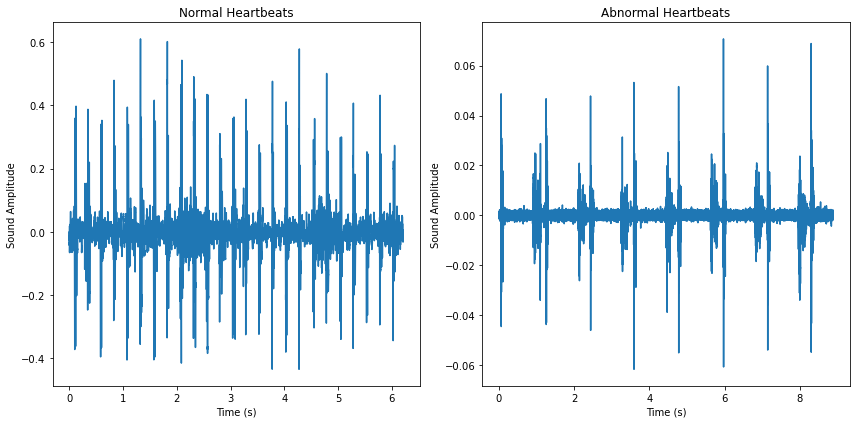

In [20]:


# Read in the first audio file from each folder for plotting
normal_audio, normal_sfreq = lr.load(glob(normal_dir + '/*.wav')[0])
abnormal_audio, abnormal_sfreq = lr.load(glob(abnormal_dir + '/*.wav')[0])

# Create time arrays for plotting
normal_time = np.arange(0, len(normal_audio)) / normal_sfreq
abnormal_time = np.arange(0, len(abnormal_audio)) / abnormal_sfreq

# Create subplots for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot normal heartbeat audio
axs[0].plot(normal_time, normal_audio)
axs[0].set(xlabel='Time (s)', ylabel='Sound Amplitude')

# Plot abnormal heartbeat audio
axs[1].plot(abnormal_time, abnormal_audio)
axs[1].set(xlabel='Time (s)', ylabel='Sound Amplitude')


# Call the function to display the plots with titles
show_plot_and_make_titles(axs[0], axs[1])


Let us mean across the datasets and see how the result looks.

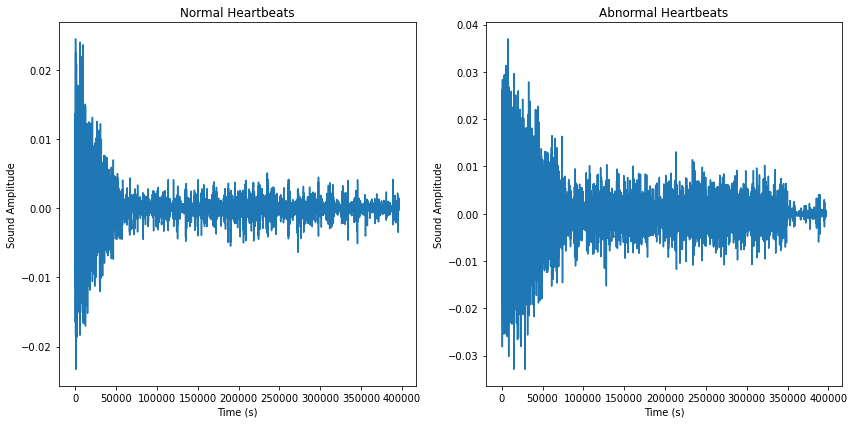

In [21]:
# Average across the audio files of each DataFrame
mean_normal = np.mean(normal, axis=1)
mean_abnormal = np.mean(abnormal, axis=1)


# Create subplots for visualization
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot mean normal heartbeat audio
axs[0].plot( mean_normal)
axs[0].set(xlabel='Time (s)', ylabel='Sound Amplitude')

# Plot mean abnormal heartbeat audio
axs[1].plot( mean_abnormal)
axs[1].set(xlabel='Time (s)', ylabel='Sound Amplitude')


# Call the function to display the plots with titles
show_plot_and_make_titles(axs[0], axs[1])


From the visualization above, we get the intuition that abnormal heartbeats have more standard deviation (almost twice) than normal ones. Since normal heartbeats are rhythmic beats, this gives us the initial intuition that out of sync heartbeats are abnormal heartbeats.